# A4: Transfer Learning with ViT and Transformer Decoder for Image Captioning Task



#### Before we start, please put your name and ID in following format ( 5 points )
: LASTNAME Firstname. e.g.陳緯閔, M123456789

Your Answer:
Hi I'm xxx, xxxxxxxxx

配分說明

TODO 實作：80 分

完成 Notebook 中所有指定的程式設計任務（TODO 標記區域）

報告（Report）：10 分

簡要說明實作內容、設計選擇、遇到的問題與解決方式

加分題：10 分

根據測試集（test set）上取得的 sacreBLEU 分數進行加分

計算方式: 全班分數進行排名，排名前 10% 的加 10 分，10% < 排名 ≤ 30% 的加 8 分，以此類推，排名最後 10% 不加分

Scoring Criteria

TODO : 80 points

Complete all programming tasks marked with TODO in the notebook.

Report: 10 points

A brief write-up explaining your implementation, design choices, challenges encountered, and how you addressed them.

Bonus: 10 points

Bonus points are awarded based on the sacreBLEU score obtained on the test set.

Scores are ranked across the entire class:
the top 10% receive +10 points,
the next 10%–30% receive +8 points, and so on,
while the bottom 10% receive no bonus points.

## Introduction

In this assignment, you will explore Vision Transformer (ViT) architectures and Transformer Decoders by building a model that performs image captioning on the Flickr8k dataset.

Your task is to:
 - Use a pre-trained Vision Transformer (ViT) as the image encoder to extract visual features.
 - Implement a Transformer Decoder from scratch to generate captions based on the extracted features.
 - Train the model to generate descriptive captions for images using the Flickr8k dataset.
 - Evaluate the model's performance using the BLEU score.



> **Dataset Description**

The Flickr8k dataset is a benchmark dataset widely used for research on image captioning tasks. It contains 8,000 images, each associated with five human-written descriptive sentences. These images are collected from the Flickr website and mainly depict people and animals performing various actions in natural scenarios. The diversity of scenes and objects makes it an ideal resource for training and evaluating models that connect visual content with natural language descriptions.

> **Assignment Constraints**
1. Do not modify the dataset. Do not use the test data during training.

2. Do not directly use PyTorch’s nn.Transformer.

3. Do not plagiarize.

## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk

## Step 1. Setup and Imports ( 5 points )


First, import necessary libraries and setup device.

In [1]:
#If the following modules are not already installed in your environment, please download and install them before running the program
!pip install "transformers>=4.44" "accelerate>=0.33" "datasets>=2.20" evaluate sacrebleu torch torchvision


In [2]:

import os, math, json, random
from typing import Optional, List, Dict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import ViTModel, AutoImageProcessor, AutoTokenizer, set_seed
from datasets import load_dataset
import evaluate
from PIL import Image
import matplotlib.pyplot as plt
import random

print("Torch:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
set_seed(42)

Torch: 2.9.0.dev20250828+cu128
Device: cuda


### Training settings

In [ ]:
########################################################################
# TODO: You can adjust the training settings to improve the score.
########################################################################

# ============================================================
# # Model configs
# VIT_NAME: specifies which Vision Transformer model to use.
# TOK_NAME: specifies which tokenizer model to use.
# ============================================================

VIT_NAME = "google/vit-large-patch16-224-in21k"
TOK_NAME = "gpt2"


# ============================================================
# # Transformer settings
# MAX_LEN: the maximum token length of captions.
# D_MODEL: the hidden dimension size of the Transformer layers.
# N_HEAD: the number of attention heads.
# FFN_DIM: the intermediate dimension of the Feed-Forward Network.
# N_LAYERS: the number of Transformer decoder layers.
# DROPOUT: dropout probability.
# ============================================================
MAX_LEN   = 32
D_MODEL   = 512
N_HEAD    = 8
FFN_DIM   = 2048
N_LAYERS  = 4
DROPOUT   = 0.1

# ============================================================
# # Training parameters
# LR: the learning rate.
# BATCH_SIZE: the number of samples processed per training step.
# EPOCHS: number of full training cycles over the dataset.
# ============================================================

LR = 3e-4
BATCH_SIZE= 32
EPOCHS = 15

# ============================================================
# # Generation
# GEN_MAX_LEN: maximum caption length during inference.
# ============================================================

GEN_MAX_LEN = 32

########################################################################
#                           End of your code
########################################################################



## Step 2. Prepare Flickr8k Dataset ( 5 points )

- Load Flickr8k dataset and visualize some samples

- Introduction of Flickr8k dataset:
  - Images depict diverse scenes including people, animals, and natural environments
  - Each image is associated with 5 human-written descriptive captions
  - Training set: 6,000 images
  - Validation set: 1,000 images
  - Test set: 1,000 images

### Data Download

In [4]:
ds = load_dataset("jxie/flickr8k")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})


### Visualize Sample Images and Captions

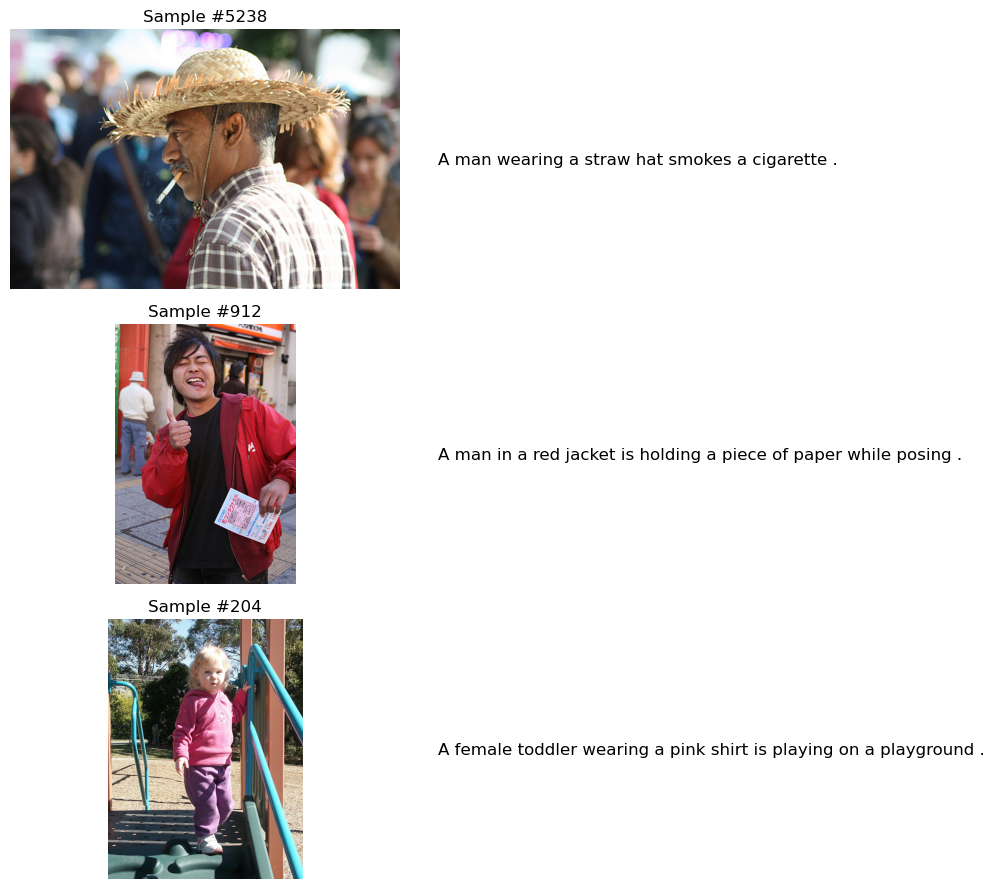

In [5]:
def show_random_samples(ds, split="train", num_samples=5, seed=None):
    subset = ds[split]
    total = len(subset)
    if total == 0:
        raise ValueError(f"No samples found in split '{split}'")

    if seed is not None:
        random.seed(seed)

    indices = random.sample(range(total), k=min(num_samples, total))
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 3 * len(indices)))
    plt.subplots_adjust(wspace=0.4)

    if len(indices) == 1:
        axes = [axes]

    for ax_pair, idx in zip(axes, indices):
        sample = subset[idx]
        image = sample["image"]
        caption = sample.get("caption", sample.get("caption_0", "(無 caption)"))

        ax_img, ax_txt = ax_pair


        ax_img.imshow(image)
        ax_img.set_title(f"Sample #{idx}", fontsize=12)
        ax_img.axis("off")


        ax_txt.axis("off")
        ax_txt.text(0, 0.5, caption, fontsize=12, va="center")

    plt.tight_layout()
    plt.show()


show_random_samples(ds, split="train", num_samples=3)

### Transfer ViT and Tokenizer
In this section, we load the pre-trained Vision Transformer (ViT) model and tokenizer. The ViT serves as the image encoder to extract visual features, while the tokenizer handles text processing for captions.

We also set up special tokens for the tokenizer:
 - **BOS** (Beginning of Sequence): Marks the start of a caption sequence.
 - **EOS** (End of Sequence): Marks the end of a caption sequence.
 - **PAD** (Padding): Used to pad sequences to a uniform length for batch processing.

In [6]:

image_processor = AutoImageProcessor.from_pretrained(VIT_NAME)
tokenizer = AutoTokenizer.from_pretrained(TOK_NAME)

print("After updating special tokens:", tokenizer.special_tokens_map)
########################################################################
# TODO: set up special tokens for BOS, EOS, PAD
# hint use add_special_tokens
########################################################################

# Add special tokens for BOS, EOS, and PAD
tokenizer.add_special_tokens({
    'bos_token': '<BOS>',
    'eos_token': '<EOS>',
    'pad_token': '<PAD>'
})



########################################################################
#                           End of your code
########################################################################
print("BOS:", tokenizer.bos_token, tokenizer.bos_token_id)
print("EOS:", tokenizer.eos_token, tokenizer.eos_token_id)
print("PAD:", tokenizer.pad_token, tokenizer.pad_token_id)
print("Before special tokens:", tokenizer.special_tokens_map)

VOCAB_SIZE = len(tokenizer)
print("vocab size:", VOCAB_SIZE)




Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


After updating special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}
BOS: <BOS> 50257
EOS: <EOS> 50258
PAD: <PAD> 50259
Before special tokens: {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>'}
vocab size: 50260


### DataLoader

In [7]:
def collate_fn(batch):
    images = [b["image"].convert("RGB") if isinstance(b["image"], Image.Image) else Image.fromarray(b["image"]) for b in batch]
    caption_cols = [k for k in batch[0].keys() if isinstance(k, str) and k.startswith("caption_")]

    def pick_caption(sample):
        if isinstance(sample, dict):
            for key in ("caption", "text"):
                val = sample.get(key)
                if isinstance(val, str) and val.strip():
                    return val
            if "captions" in sample and sample["captions"] is not None:
                caps = sample["captions"]
                if isinstance(caps, list):
                    for c in caps:
                        if isinstance(c, str) and c.strip():
                            return c
                elif isinstance(caps, dict):
                    for key in ("text", "caption", "captions"):
                        val = caps.get(key)
                        if isinstance(val, list):
                            for c in val:
                                if isinstance(c, str) and c.strip():
                                    return c
                        elif isinstance(val, str) and val.strip():
                            return val
            for col in caption_cols:
                val = sample.get(col)
                if isinstance(val, str) and val.strip():
                    return val
        return ""

    captions = [pick_caption(b) for b in batch]
    
    # 🔥 手動添加 BOS 和 EOS tokens
    captions_with_special = [
        f"{tokenizer.bos_token} {cap} {tokenizer.eos_token}"
        for cap in captions
    ]
    
    # Tokenize (不要自動添加 special tokens,因為我們已經手動添加了)
    encoded = tokenizer(
        captions_with_special,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt',
        add_special_tokens=False  # 重要!
    )
    
    pix = image_processor(images, return_tensors='pt')
    return {
        "pixel_values": pix["pixel_values"],
        "input_ids": encoded["input_ids"],
    }

train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(ds["validation"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

batch = next(iter(train_loader))
tuple(t.shape if isinstance(t, torch.Tensor) else type(t) for t in batch.values())


(torch.Size([32, 3, 224, 224]), torch.Size([32, 32]))

## Step 3. Use the Pre-trained ViT model ( 5 points )
In this section, we load and configure the pre-trained Vision Transformer (ViT) model to serve as the image encoder. The ViT extracts visual features from input images, which are then used by the Transformer Decoder to generate captions.

In [8]:

########################################################################
# TODO:
# Currently, all ViT encoder layers are frozen.
# You may unfreeze certain layers to fine-tune the model for better scores,
# or you can proceed to test other parts of the pipeline first.
########################################################################

vit = ViTModel.from_pretrained(VIT_NAME)
for p in vit.parameters():
    p.requires_grad = False
vit.eval().to(device)
vit.config.hidden_size


########################################################################
#                           End of your code
########################################################################

1024

## Step 4. Construct Transformer Decoder ( 33 points )
In this section, we implement the Transformer Decoder from scratch, which is a main component of the image captioning model. The Transformer Decoder is responsible for generating descriptive captions.

### Positional Encoding

The Transformer model itself has no recurrence (RNN) or convolution (CNN) structures, so it cannot inherently recognize the order of tokens in an input sequence.
To help the model understand the relative or absolute positions of words within a sequence, we must inject positional information.

In this assignment, we implement the Positional Encoding method proposed in the original Transformer paper.
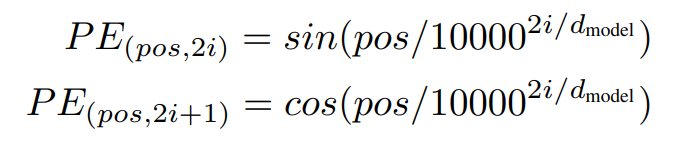


For more details about the Transformer architecture, please refer to the paper

Ashish Vaswani et al., “Attention Is All You Need”, NeurIPS 2017.
 [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

In [10]:
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
########################################################################
# TODO:
# Implement sinusoidal positional encoding as proposed in the Transformer
# - Precompute a [1, max_len, d_model] positional encoding matrix
# - Register it as a non-learnable buffer in the module
# - In the forward pass, add positional encoding to the input embeddings
# ( 5 points )
########################################################################


    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
          # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: input tensor of shape [batch_size, seq_len, d_model]
        Adds positional encoding to input tensor, up to seq_len.

        """
        B, T, D = x.shape
        return x + self.pe[:, :T, :]


########################################################################
#                           End of your code
########################################################################


class MultiHeadAttention(nn.Module):
########################################################################
# TODO:
# Implement Scaled Dot-Product Multi-Head Attention:
# - Project queries, keys, and values using linear layers
# - Split into multiple heads and compute attention per head
# - Apply scaling factor and (optional) attention mask
# - Concatenate all attention outputs and project back to d_model
# ( 10 points )
########################################################################
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def _shape(self, x: torch.Tensor, B: int, T: int) -> torch.Tensor:
        """
        x reshape:
        [batch, seq_len, d_model] -> [batch, num_heads, seq_len, head_dim]
        """
        return x.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, attn_mask: Optional[torch.Tensor] = None):
        """
        Multi-Head Attention forward pass.

        Args:
            Q: Query tensor of shape [batch, Tq, d_model]
            K: Key tensor of shape   [batch, Tk, d_model]
            V: Value tensor of shape [batch, Tk, d_model]
            attn_mask: Optional attention mask of shape [batch, num_heads, Tq, Tk]

        Returns:
            Output tensor of shape [batch, Tq, d_model]
        """
        B, Tq, _ = Q.shape
        _, Tk, _ = K.shape
        
        # Project Q, K, V
        Q = self.q_proj(Q)
        K = self.k_proj(K)
        V = self.v_proj(V)
        
        # Reshape to [B, num_heads, T, head_dim]
        Q = self._shape(Q, B, Tq)
        K = self._shape(K, B, Tk)
        V = self._shape(V, B, Tk)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)
        
        # Reshape back: [B, num_heads, Tq, head_dim] -> [B, Tq, d_model]
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, Tq, self.d_model)
        
        # Final projection
        out = self.out_proj(attn_output)
        return out
########################################################################
#                           End of your code
########################################################################


class FeedForward(nn.Module):
########################################################################
# TODO:
# Implement Position-wise Feed-Forward Network (FFN) used in Transformer blocks:
# - Consists of two linear layers with a non-linear activation in between
# - Expands dimension from d_model to dim_ff, then projects back to d_model
# - Includes optional dropout to reduce overfitting
# ( 5 points )
########################################################################
    def __init__(self, d_model: int, dim_ff: int, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(d_model, dim_ff),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(dim_ff, d_model),
        nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        x shape: [batch, seq_len, d_model]
        Returns: [batch, seq_len, d_model]
        """
        return self.net(x)
########################################################################
#                           End of your code
########################################################################


class TransformerDecoderLayer(nn.Module):
########################################################################
# TODO:
# Implement a single layer of the Transformer Decoder, including:
# - Masked Self-Attention (prevents attending to future tokens)
# - Cross-Attention (attends to encoder output)
# - Position-wise Feedforward Network
# - Residual connections + Layer Normalization
# ( 8 points )
########################################################################
    def __init__(self, d_model: int, num_heads: int, dim_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForward(d_model, dim_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc, causal_mask: Optional[torch.Tensor] = None):
        """
        Args:
            x: Decoder input embeddings [batch, tgt_seq_len, d_model]
            enc: Encoder output representations [batch, src_seq_len, d_model]
            causal_mask: Optional attention mask for target-side self-attention

        Returns:
            Updated decoder output of shape [batch, tgt_seq_len, d_model]
        """
        # Masked self-attention
        x_norm = self.norm1(x)
        attn_out = self.self_attn(x_norm, x_norm, x_norm, causal_mask)
        x = x + self.dropout(attn_out)
        
        # Cross-attention
        x_norm = self.norm2(x)
        attn_out = self.cross_attn(x_norm, enc, enc)
        x = x + self.dropout(attn_out)
        
        # Feed-forward
        x_norm = self.norm3(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout(ffn_out)
        return x
########################################################################
#                           End of your code
########################################################################


class TransformerDecoder(nn.Module):
########################################################################
# TODO:
# Build a Transformer Decoder composed of multiple stacked decoder layers:
# - Each layer contains masked self-attention, cross-attention, and feedforward blocks
# - Supports using a causal mask for autoregressive generation
# - Ends with a final LayerNorm for output stabilization
# ( 5 points )
########################################################################


    def __init__(self, d_model: int, num_layers: int, num_heads: int, dim_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
        TransformerDecoderLayer(d_model, num_heads, dim_ff, dropout)
            for _ in range(num_layers)
        ])
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, enc, causal_mask: Optional[torch.Tensor] = None):
        
        for layer in self.layers:
            x = layer(x, enc, causal_mask)
        return self.ln(x)
########################################################################
#                           End of your code
########################################################################

## Step 5. Build the Image Captioning Model ( 10 points )
In this section, we define the CaptionModel class, which integrates the pre-trained Vision Transformer (ViT) as the image encoder and the custom Transformer Decoder as the caption generator. The model takes an image as input, extracts visual features using ViT, and generates descriptive captions autoregressively using the Transformer Decoder.

In [11]:
class CaptionModel(nn.Module):
    def __init__(self, vit: ViTModel, vocab_size: int, d_model=512, n_heads=8, dim_ff=2048, n_layers=4, dropout=0.1):
        super().__init__()
        self.vit = vit
        self.vit_proj = nn.Linear(vit.config.hidden_size, d_model)
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=512)
        self.decoder = TransformerDecoder(d_model, n_layers, n_heads, dim_ff, dropout)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def encode_image(self, pixel_values: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            out = self.vit(pixel_values=pixel_values)
            feats = out.last_hidden_state
        return self.vit_proj(feats)

    def forward(self, pixel_values: torch.Tensor, input_ids: torch.Tensor):
        x_in  = input_ids[:, :-1].contiguous()
        x_tgt = input_ids[:, 1:].contiguous()

        enc = self.encode_image(pixel_values)

        x = self.token_emb(x_in)
        x = self.pos_enc(x)

        B, T, _ = x.shape
        causal_mask = torch.triu(torch.ones(T, T, dtype=torch.bool, device=x.device), diagonal=1)[None, None, :, :]

        dec = self.decoder(x, enc, causal_mask)
        logits = self.lm_head(dec)
        return logits, x_tgt

    @torch.no_grad()

    def generate_greedy(self, pixel_values: torch.Tensor, bos_id: int, eos_id: int, max_len: int = 32):
    ########################################################################
    # TODO:
    # Greedy decoding for image-to-text generation (e.g., captioning).
    # - Starts with the BOS (beginning-of-sequence) token.
    # - At each step, selects the token with the highest probability (argmax).
    # - Stops when EOS (end-of-sequence) token is generated or max length is reached.
    ########################################################################
        B = pixel_values.shape[0]
        enc = self.encode_image(pixel_values)
        
        # Start with BOS token
        generated = torch.full((B, 1), bos_id, dtype=torch.long, device=pixel_values.device)
        
        for _ in range(max_len - 1):
            # Embed and add positional encoding
            x = self.token_emb(generated)
            x = self.pos_enc(x)
            
            # Create causal mask
            T = x.shape[1]
            causal_mask = torch.triu(torch.ones(T, T, dtype=torch.bool, device=x.device), diagonal=1)[None, None, :, :]
            
            # Decode
            dec = self.decoder(x, enc, causal_mask)
            logits = self.lm_head(dec)
            
            # Get next token (greedy)
            next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            
            # Check if all sequences have generated EOS
            if (next_token == eos_id).all():
                break
        
        return generated


    ########################################################################
    #                           End of your code
    ########################################################################

### Sanity Check

In [14]:
model = CaptionModel(vit, vocab_size=len(tokenizer), d_model=D_MODEL, n_heads=N_HEAD, dim_ff=FFN_DIM, n_layers=N_LAYERS, dropout=DROPOUT).to(device)
batch = next(iter(train_loader))
logits, x_tgt = model(batch["pixel_values"].to(device), batch["input_ids"].to(device))
logits.shape, x_tgt.shape


(torch.Size([32, 31, 50260]), torch.Size([32, 31]))

## Step 6. Model Training and Evaluation ( 17 points )

### Define loss and optimizer ( 3 points )

In [15]:
########################################################################
# TODO: Define loss and optmizer functions
# use Cross Entropy and any optimizer you like
# hint: torch.nn and torch.optim
########################################################################


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

########################################################################
#                           End of your code
########################################################################

### Train and evaluate function ( 14 points )

In [16]:
def train():
########################################################################
# TODO:
# - Set the model to training mode
# - Load batches of image-caption pairs from train_loader
# - Forward pass: encode images & decode captions
# - Compute loss
# - Backpropagate, apply gradient clipping, and update model weights
# - Accumulate and return average loss across all batches
########################################################################
    model.train()
    total = 0.0
    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        
        # Forward pass
        logits, x_tgt = model(pixel_values, input_ids)
        
        # Compute loss
        loss = criterion(logits.reshape(-1, logits.shape[-1]), x_tgt.reshape(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        total += loss.item()
########################################################################
#                           End of your code
########################################################################
    return total / max(1, len(train_loader))

@torch.no_grad()
def eval_bleu(loader):

    model.eval()
    bleu = evaluate.load("sacrebleu")
    preds, refs = [], []
########################################################################
# TODO:
# - Set BOS (beginning-of-sequence) and EOS (end-of-sequence) token IDs
# - Loop over the data loader:
#   * Get pixel values (images) and move to the correct device
#   * Generate predicted captions using greedy decoding
#   * Decode token IDs into text strings
#   * Collect corresponding ground-truth captions from the batch
########################################################################
    bos = tokenizer.bos_token_id
    eos = tokenizer.eos_token_id
    for batch in loader:
        pix = batch["pixel_values"].to(device)
        gen_ids = model.generate_greedy(pix, bos, eos, max_len=GEN_MAX_LEN)
        
        # Decode predictions
        for gen_id in gen_ids:
            # 🔥 截斷到 EOS
            gen_list = gen_id.tolist()
            if eos in gen_list:
                eos_idx = gen_list.index(eos)
                gen_id = gen_id[:eos_idx]
            
            text = tokenizer.decode(gen_id, skip_special_tokens=True)
            # 清理文本
            text = text.replace(' .', '.').replace(' ,', ',')
            text = text.replace(' !', '!').replace(' ?', '?')
            text = ' '.join(text.split())
            preds.append(text.strip())
        
        # Reference captions
        for input_id in batch["input_ids"]:
            ref_list = input_id.tolist()
            if eos in ref_list:
                eos_idx = ref_list.index(eos)
                input_id = input_id[:eos_idx]
            
            text = tokenizer.decode(input_id, skip_special_tokens=True)
            text = text.replace(' .', '.').replace(' ,', ',')
            text = ' '.join(text.split())
            refs.append([text.strip()])
    
    result = bleu.compute(predictions=preds, references=refs, force=True)
########################################################################
#                           End of your code
########################################################################
    return result["score"]
for ep in range(1, EPOCHS+1):
    tr = train()
    sc = eval_bleu(val_loader)
    print(f"Epoch {ep:02d} | loss={tr:.4f} | sacreBLEU={sc:.2f}")

Epoch 01 | loss=4.1974 | sacreBLEU=3.39
Epoch 02 | loss=2.9740 | sacreBLEU=6.81
Epoch 03 | loss=2.5193 | sacreBLEU=8.34
Epoch 04 | loss=2.1450 | sacreBLEU=8.07
Epoch 05 | loss=1.8004 | sacreBLEU=8.81


In [18]:
for ep in range(6, 16):  # 從第 6 epoch 開始
    tr = train()
    sc = eval_bleu(val_loader)
    print(f"Epoch {ep:02d} | loss={tr:.4f} | sacreBLEU={sc:.2f}")

Epoch 06 | loss=1.4597 | sacreBLEU=8.69
Epoch 07 | loss=1.1347 | sacreBLEU=8.27
Epoch 08 | loss=0.8456 | sacreBLEU=7.55
Epoch 09 | loss=0.6076 | sacreBLEU=7.38
Epoch 10 | loss=0.4319 | sacreBLEU=7.08
Epoch 11 | loss=0.3118 | sacreBLEU=7.15
Epoch 12 | loss=0.2249 | sacreBLEU=6.61
Epoch 13 | loss=0.1767 | sacreBLEU=6.74
Epoch 14 | loss=0.1398 | sacreBLEU=6.88
Epoch 15 | loss=0.1153 | sacreBLEU=6.41


In [19]:
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
final_bleu = eval_bleu(test_loader)
print(f"Final Test sacreBLEU: {final_bleu:.2f}")

Final Test sacreBLEU: 6.57


In [20]:
model = CaptionModel(
    vit, 
    vocab_size=len(tokenizer), 
    d_model=D_MODEL, 
    n_heads=N_HEAD, 
    dim_ff=FFN_DIM, 
    n_layers=N_LAYERS, 
    dropout=DROPOUT
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)

best_bleu = 0
patience = 3
patience_counter = 0

for ep in range(1, 20):  # 最多 20,但會提前停止
    tr_loss = train()
    val_bleu = eval_bleu(val_loader)
    print(f"Epoch {ep:02d} | loss={tr_loss:.4f} | BLEU={val_bleu:.2f}")
    
    if val_bleu > best_bleu:
        best_bleu = val_bleu
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  ✓ New best: {best_bleu:.2f}")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nStopped at epoch {ep}. Best BLEU: {best_bleu:.2f}")
        break

# 載入最佳模型測試
model.load_state_dict(torch.load('best_model.pt'))
test_bleu = eval_bleu(test_loader)
print(f"Final Test BLEU: {test_bleu:.2f}")

Epoch 01 | loss=5.0673 | BLEU=4.52
  ✓ New best: 4.52
Epoch 02 | loss=4.0433 | BLEU=6.93
  ✓ New best: 6.93
Epoch 03 | loss=3.6448 | BLEU=8.29
  ✓ New best: 8.29
Epoch 04 | loss=3.3210 | BLEU=7.80
Epoch 05 | loss=3.0175 | BLEU=8.36
  ✓ New best: 8.36
Epoch 06 | loss=2.7210 | BLEU=7.95
Epoch 07 | loss=2.4387 | BLEU=8.66
  ✓ New best: 8.66
Epoch 08 | loss=2.1883 | BLEU=7.76
Epoch 09 | loss=1.9907 | BLEU=7.82
Epoch 10 | loss=1.8391 | BLEU=7.94

Stopped at epoch 10. Best BLEU: 8.66
Final Test BLEU: 8.52


In [24]:
# 重新開始,解凍 ViT
vit = ViTModel.from_pretrained(VIT_NAME)

# 凍結大部分
for p in vit.parameters():
    p.requires_grad = False

# 解凍最後 2 層
for name, param in vit.named_parameters():
# 針對 ViT-Large (24層)，最後兩層是 22 和 23
    if 'encoder.layer.23' in name or 'encoder.layer.22' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

vit.to(device)

# 重新創建模型
model = CaptionModel(
    vit, 
    vocab_size=len(tokenizer), 
    d_model=D_MODEL, 
    n_heads=N_HEAD, 
    dim_ff=FFN_DIM, 
    n_layers=N_LAYERS, 
    dropout=0.2  # 增加 dropout
).to(device)

# 將參數分組
vit_params = list(map(id, model.vit.parameters()))
decoder_params = filter(lambda p: id(p) not in vit_params, model.parameters())

optimizer = torch.optim.AdamW([
    {'params': model.vit.parameters(), 'lr': 1e-5},  # ViT 使用極低學習率
    {'params': decoder_params, 'lr': 3e-4}           # Decoder 使用正常學習率
], weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)

# 訓練 with early stopping
best_bleu = 0
patience = 3

for ep in range(1, 20):
    tr_loss = train()
    val_bleu = eval_bleu(val_loader)
    print(f"Epoch {ep:02d} | loss={tr_loss:.4f} | BLEU={val_bleu:.2f}")
    
    if val_bleu > best_bleu:
        best_bleu = val_bleu
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_v2.pt')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        break

# 載入最佳模型測試
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
model.load_state_dict(torch.load('best_model_v2.pt'))
test_bleu = eval_bleu(test_loader)
print(f"Final Test BLEU: {test_bleu:.2f}")

Epoch 01 | loss=5.1217 | BLEU=3.41
Epoch 02 | loss=4.1168 | BLEU=6.84
Epoch 03 | loss=3.7475 | BLEU=8.09
Epoch 04 | loss=3.4569 | BLEU=8.26
Epoch 05 | loss=3.1963 | BLEU=8.94
Epoch 06 | loss=2.9497 | BLEU=9.01
Epoch 07 | loss=2.7065 | BLEU=8.07
Epoch 08 | loss=2.4803 | BLEU=8.42
Epoch 09 | loss=2.2786 | BLEU=8.37
Final Test BLEU: 9.09


In [23]:
print(vit)
print(len(vit.encoder.layer))

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=True)
          (intermediate_act_fn

## Step 7. Evaluation of Image and Caption Prediction

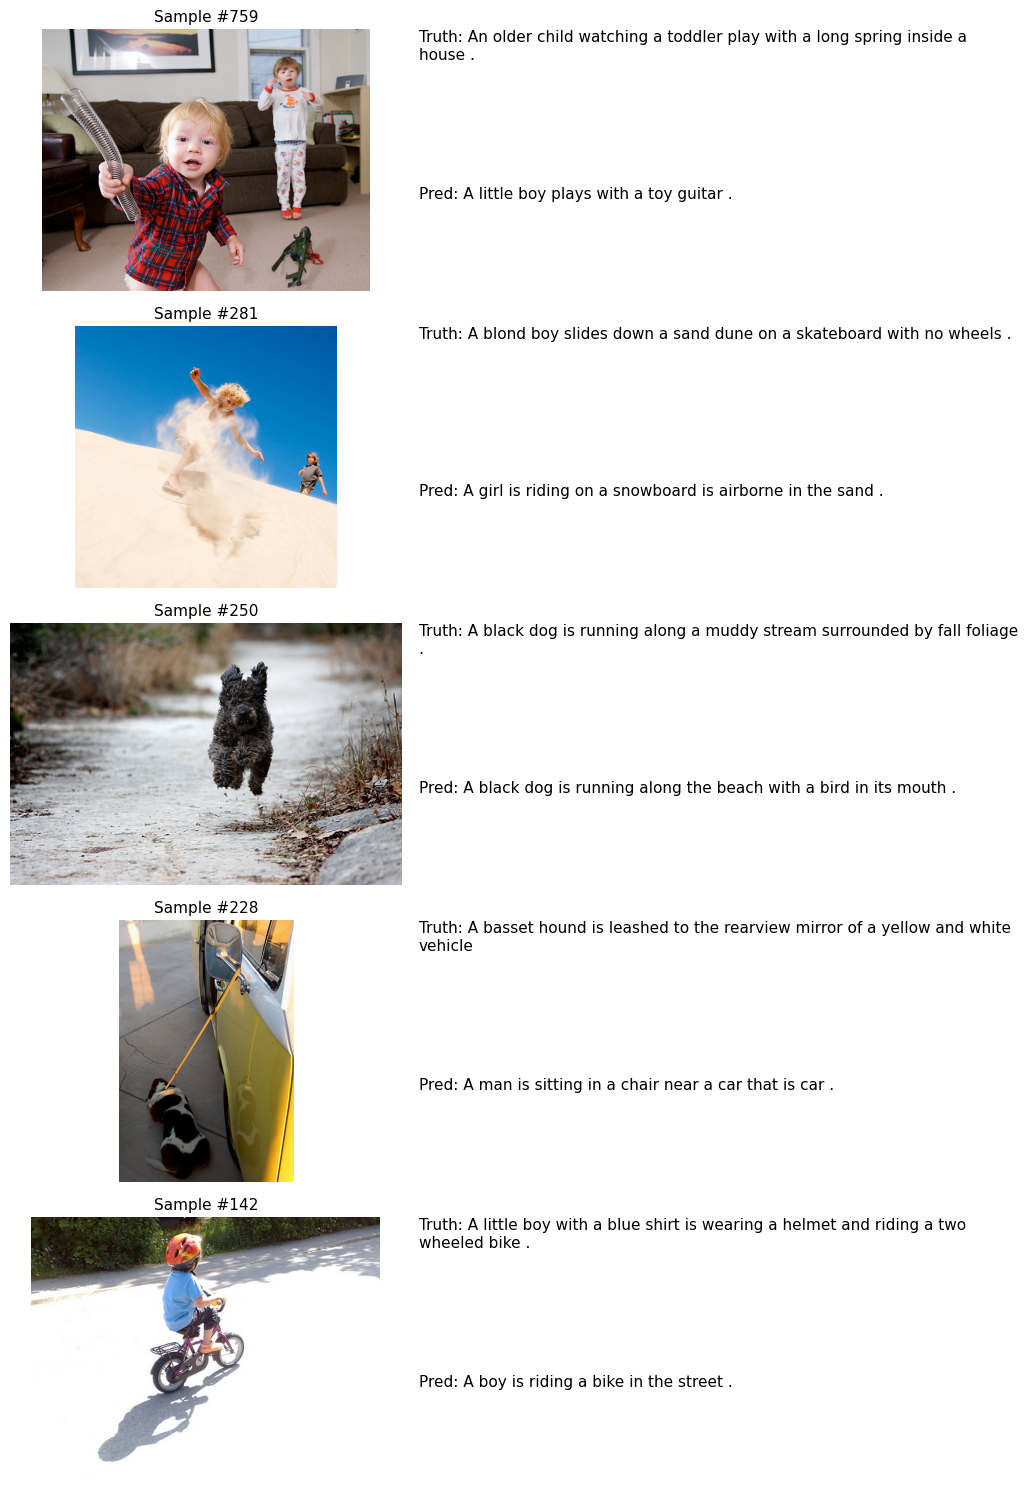

In [17]:

import matplotlib.pyplot as plt
from textwrap import fill

@torch.no_grad()
def show_predictions(split="test", num_samples=5):
    """Visualize samples with ground-truth and predicted captions side by side."""
    model.eval()
    subset = ds[split]
    total = len(subset)
    if total == 0:
        raise ValueError(f"Split '{split}' has no samples")
    count = min(num_samples, total)
    picks = random.sample(range(total), k=count)
    bos = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
    eos = tokenizer.eos_token_id

    def pick_caption(sample):
        for key in ("caption", "text"):
            val = sample.get(key)
            if isinstance(val, str) and val.strip():
                return val
        if "captions" in sample and sample["captions"] is not None:
            caps = sample["captions"]
            if isinstance(caps, list):
                for c in caps:
                    if isinstance(c, str) and c.strip():
                        return c
            elif isinstance(caps, dict):
                for key in ("text", "caption", "captions"):
                    val = caps.get(key)
                    if isinstance(val, list):
                        for c in val:
                            if isinstance(c, str) and c.strip():
                                return c
                    elif isinstance(val, str) and val.strip():
                        return val
        for key, val in sample.items():
            if isinstance(key, str) and key.startswith("caption_") and isinstance(val, str) and val.strip():
                return val
        return ""

    fig, axes = plt.subplots(count, 2, figsize=(12, 3 * count))
    if count == 1:
        axes = [axes]

    for (ax_img, ax_txt), idx in zip(axes, picks):
        sample = subset[idx]
        image = sample["image"].convert("RGB") if isinstance(sample["image"], Image.Image) else Image.fromarray(sample["image"])
        pix = image_processor(images=image, return_tensors="pt").pixel_values.to(device)
        tokens = model.generate_greedy(pix, bos_id=bos, eos_id=eos, max_len=GEN_MAX_LEN)
        pred = tokenizer.decode(tokens[0], skip_special_tokens=True).strip()
        ref = pick_caption(sample) or "(no caption found)"

        ax_img.imshow(image)
        ax_img.set_title(f"Sample #{idx}", fontsize=11)
        ax_img.axis("off")

        ax_txt.axis("off")
        truth_text = f"Truth: {fill(ref, 70)}"
        pred_text = f"Pred: {fill(pred, 70)}"
        ax_txt.text(0, 1.0, truth_text, fontsize=11, va="top")
        ax_txt.text(0, 0.4, pred_text, fontsize=11, va="top")

    plt.tight_layout()

show_predictions(split="test", num_samples=5)
